In [117]:
import SimpleITK as sitk
import numpy as np
import cv2
import matplotlib.pyplot as plt

IMG1 = sitk.ReadImage('/home/ngaggion/Documentos/Leeds/Dataset/1000739/time001/SAX.nii.gz')
IMG2 = sitk.ReadImage('/home/ngaggion/Documentos/Leeds/Dataset/1000739/time001/LAX/2CH/0001')

mesh = np.load("/home/ngaggion/Documentos/Leeds/Dataset/1000739/time001/fhm_original.npy")

M1 = np.array(IMG1.GetDirection()).reshape((3, 3))
M2 = np.array(IMG2.GetDirection()).reshape((3, 3))

# For each direction of M2, write the vectors in terms of the basis of M1

# Compute M2 in terms of the M1 basis
M2_in_M1_basis = np.dot(M1.T, M2)

scale_x = 2
scale_y = 2
scale_z = 1.0

M2_in_M1_basis[0, :] *= scale_x
M2_in_M1_basis[1, :] *= scale_y
M2_in_M1_basis[2, :] *= scale_z

aux_1 = M2.T @ (M1 @ M2_in_M1_basis) 

norms = np.diag(aux_1)

In [118]:
# scale the image using cv2, only in the x and y axis
import cv2

IMG1_array = sitk.GetArrayFromImage(IMG1).transpose(1,2,0)
IMG1_scaled = cv2.resize(IMG1_array, None, fx=scale_x, fy=scale_y, interpolation=cv2.INTER_CUBIC)
IMG1_scaled = IMG1_scaled.transpose(2,0,1)

# Create a new image with the same origin, spacing, and direction as IMG1
IMG1_scaled = sitk.GetImageFromArray(IMG1_scaled)
IMG1_scaled.SetOrigin(IMG1.GetOrigin())
IMG1_scaled.SetSpacing(IMG1.GetSpacing())
IMG1_scaled.SetDirection(IMG1.GetDirection())


In [119]:
 # Get the origin of the image
origin = np.array(IMG1.GetOrigin())

# Calculate the pixel size in each dimension
pixel_size = np.array(IMG1.GetSpacing())

# Calculate the direction matrix from the direction cosines
direction_matrix = np.array(IMG1.GetDirection()).reshape(3, 3)

# Calculate the inverse of the direction matrix
inverse_direction_matrix = np.linalg.inv(direction_matrix)

# Convert the physical points to voxel indices by subtracting the origin and multiplying with the inverse direction matrix
voxel_indices = np.dot((mesh - origin), inverse_direction_matrix.T)

# Convert the voxel indices to image space by dividing by the pixel size
image_space_points = voxel_indices / pixel_size

image_space_points[:, 0] *= scale_x
image_space_points[:, 1] *= scale_y
image_space_points[:, 2] *= scale_z

# Return the image space points to physical space by multiplying with the pixel size and multiplying with the direction matrix
physical_points = image_space_points * pixel_size 
physical_points = np.dot(physical_points, direction_matrix.T) + origin

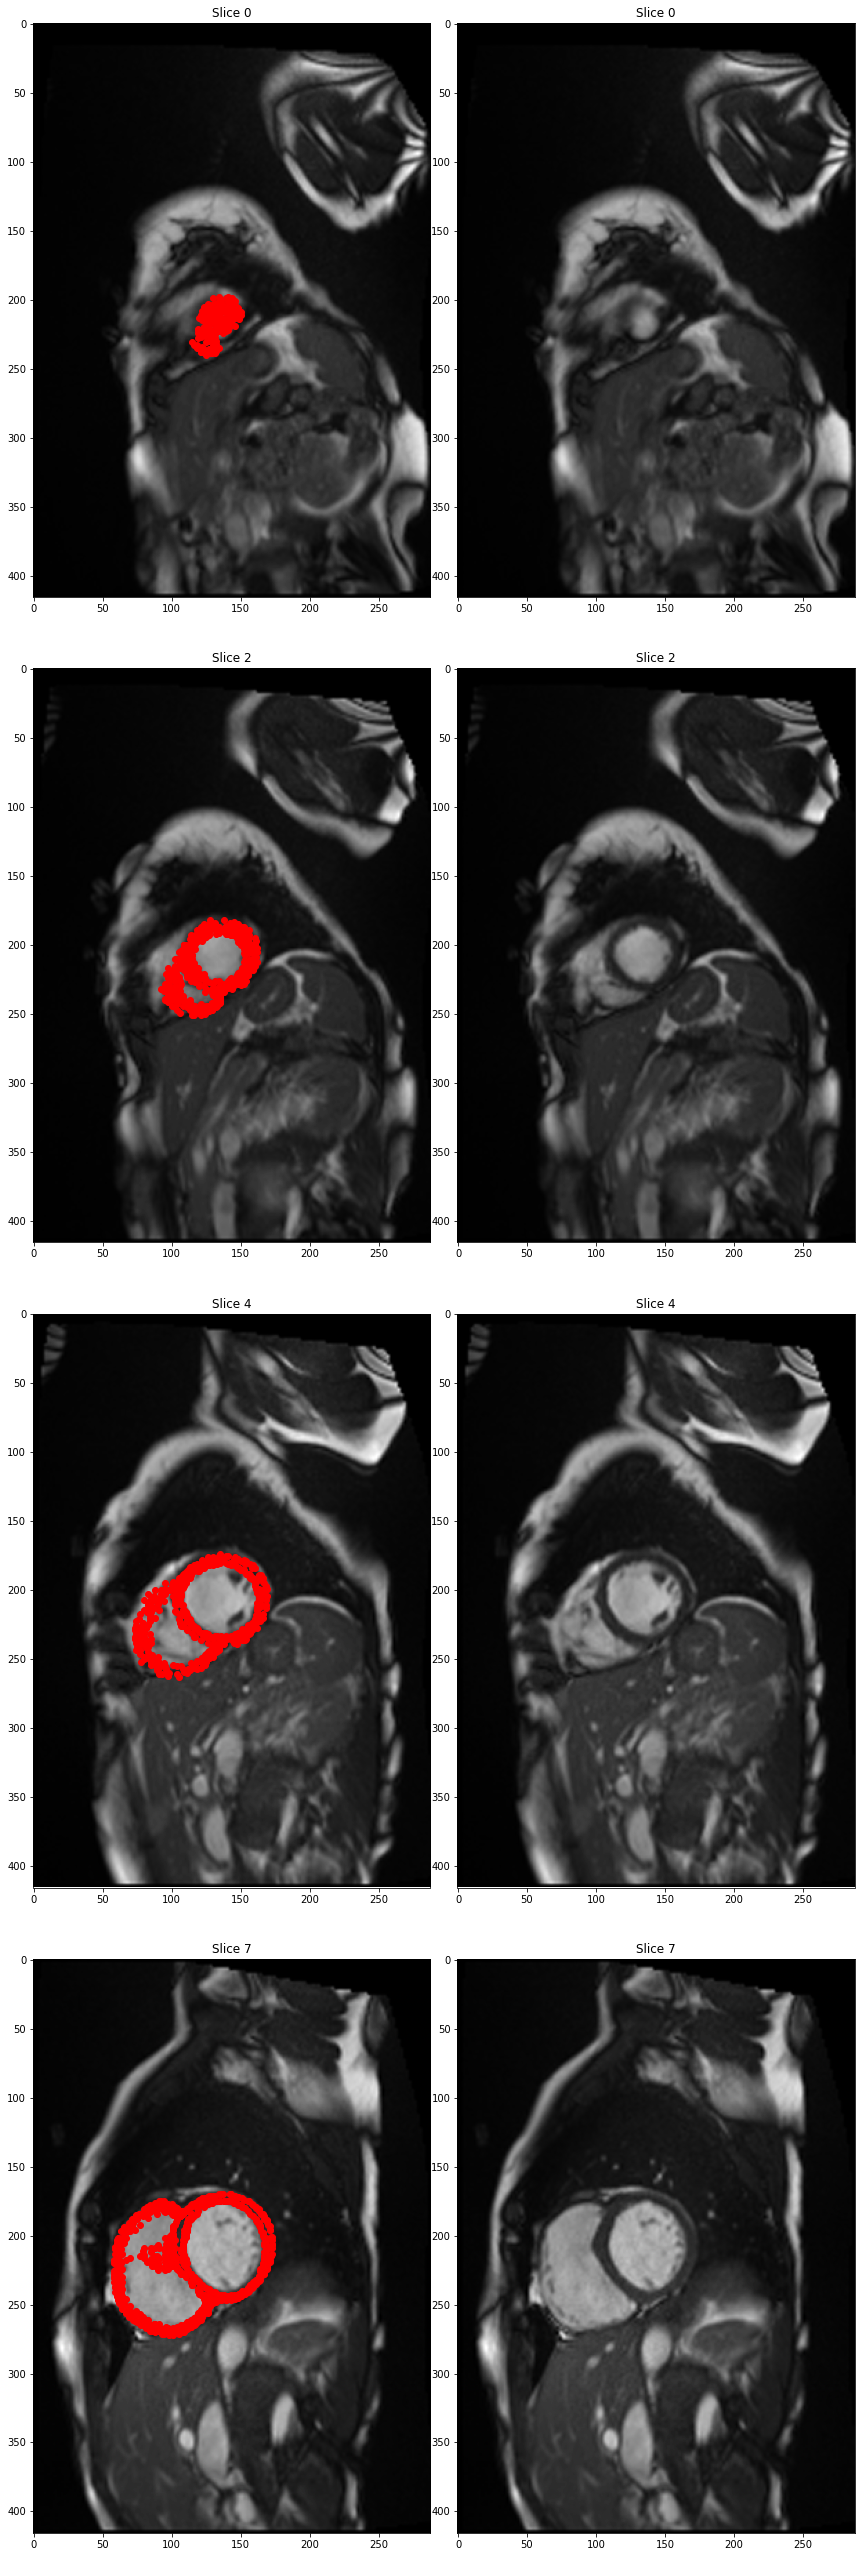

In [120]:
import matplotlib.pyplot as plt

# Define the slice indices you want to visualize
slice_indices = [0,2,4,7]

# Plot the slices with the points overlaid
fig, axs = plt.subplots(len(slice_indices), 2, figsize=(12, 36))

indices = []
for point in physical_points:
    index = IMG1_scaled.TransformPhysicalPointToIndex(point)
    indices.append(index)
points = np.array(indices)


for i, idx in enumerate(slice_indices):
    # Get the slice from the image
    img_slice =  sitk.GetArrayFromImage(IMG1_scaled)[idx, :, :]

    # Plot the image slice
    axs[i, 0].imshow(img_slice, cmap='gray')
    axs[i, 0].set_title('Slice {}'.format(idx))
    
    # Get the points in index coordinates for the current slice
    points_ = points[points[:, 2] == idx, :]
    
    # Plot the points on top of the image
    axs[i, 0].plot(points_[:, 0], points_[:, 1], 'ro') 

    # Set the aspect ratio to match the image
    axs[i, 0].set_aspect('equal')
    
    # Plot the image slice
    axs[i, 1].imshow(img_slice, cmap='gray')
    axs[i, 1].set_title('Slice {}'.format(idx))

    # Set the aspect ratio to match the image
    axs[i, 1].set_aspect('equal')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


In [121]:
IMG2_array = sitk.GetArrayFromImage(IMG2).transpose(1,2,0).astype(np.float64)
IMG2_scaled = cv2.resize(IMG2_array, None, fx=norms[0], fy=norms[1], interpolation=cv2.INTER_CUBIC)
IMG2_scaled = IMG2_scaled[np.newaxis]

IMG2_scaled = sitk.GetImageFromArray(IMG2_scaled)
IMG2_scaled.SetOrigin(IMG2.GetOrigin())
IMG2_scaled.SetSpacing(IMG2.GetSpacing())
IMG2_scaled.SetDirection(IMG2.GetDirection())

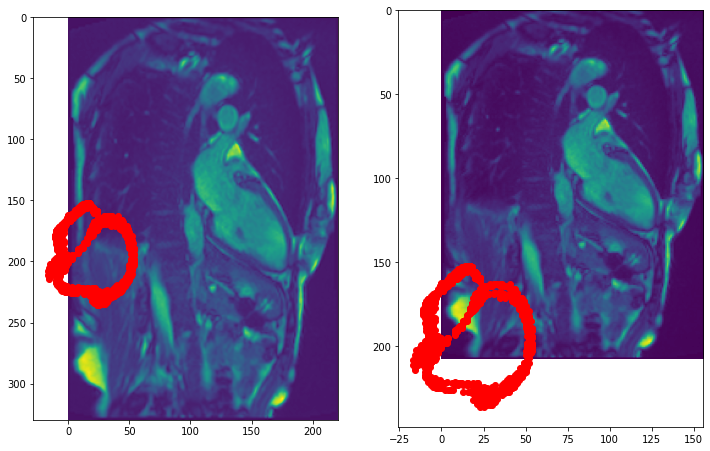

In [122]:
# Now we can plot the points into the 2D Lax images
indices = []
for point in physical_points:
    index = IMG2.TransformPhysicalPointToIndex(point)
    indices.append(index)
points = np.array(indices)

points_ = points[np.load('aux.npy'), :]

array = sitk.GetArrayFromImage(IMG2_scaled)

array_b = sitk.GetArrayFromImage(IMG2)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(array[0])
plt.plot(points_[:, 0], points_[:, 1], 'ro')


plt.subplot(1, 2, 2)
plt.imshow(array_b[0])
plt.plot(points_[:, 0], points_[:, 1], 'ro')
